In [349]:
library(quantmod)
library(ggplot2)
library(tseries)
library(rugarch)
library(lmtest)
library(moments)

In [350]:
# Download Apple data from Yahoo Finance
getSymbols("AAPL", src = "yahoo", from = '2000-01-01', to = '2019-04-01', getSymbols.yahoo.warning=FALSE)

# Show first few rows from the dataset
head(AAPL)

[1] "AAPL"

           AAPL.Open AAPL.High AAPL.Low AAPL.Close AAPL.Volume AAPL.Adjusted
2000-01-03  3.745536  4.017857 3.631696   3.997768   133949200      2.665724
2000-01-04  3.866071  3.950893 3.613839   3.660714   128094400      2.440975
2000-01-05  3.705357  3.948661 3.678571   3.714286   194580400      2.476697
2000-01-06  3.790179  3.821429 3.392857   3.392857   191993200      2.262367
2000-01-07  3.446429  3.607143 3.410714   3.553571   115183600      2.369532
2000-01-10  3.642857  3.651786 3.383929   3.491071   126266000      2.327857

In [351]:
Price = as.xts(AAPL$AAPL.Adjusted)
names(Price) = c("price")

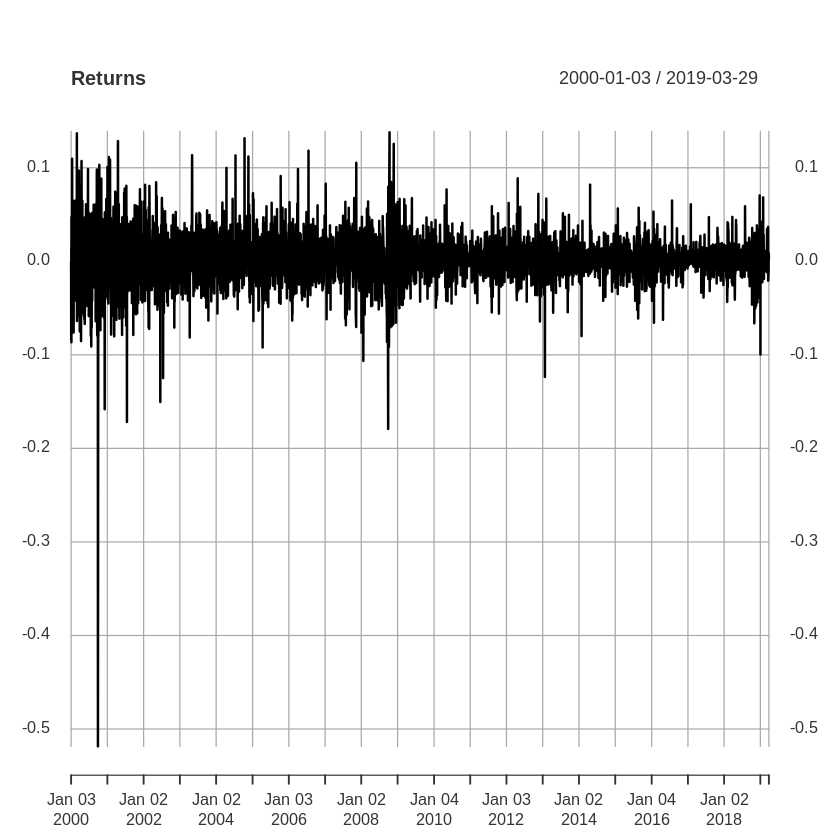

In [352]:
Returns = dailyReturn(Price)
plot(Returns)

In [353]:
# Basic normality test on the returns
returnsDf = as.data.frame(Returns)$daily.returns
shapiro.test(returnsDf)
skewness(returnsDf)
kurtosis(returnsDf)


	Shapiro-Wilk normality test

data:  returnsDf
W = 0.89249, p-value < 2.2e-16


[1] -1.628129

[1] 40.72374

In [354]:
# Stationary test on returns
adf.test(Returns)

Warning message in adf.test(Returns):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  Returns
Dickey-Fuller = -15.572, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


## GARCH Model

Since the returns is stationary, we will model the volatility with the simplest GARCH(1,1) model first to compare against other models. 

In [357]:
spec_garch_11 = ugarchspec(mean.model = list(armaOrder = c(0,0)))
show(spec_garch_11)


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



In [383]:
fit_garch_11 = ugarchfit(spec, Returns, solver='hybrid', out.sample = 30)

In [384]:
show(fit_garch_11)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001957    0.000275   7.1239 0.000000
omega   0.000006    0.000002   2.8611 0.004221
alpha1  0.070646    0.009108   7.7565 0.000000
beta1   0.923010    0.010445  88.3689 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001957    0.000291  6.71943 0.000000
omega   0.000006    0.000007  0.79615 0.425947
alpha1  0.070646    0.032051  2.20413 0.027515
beta1   0.923010    0.035988 25.64783 0.000000

LogLikelihood : 11538.93 

Information Criteria
------------------------------------
                    
Akaike       -4.7962
Bayes        -4.7908
Shibata      -4.7962
Hannan-Quinn -4.7943

Weig

In [421]:
# Forecast 15 days ahead
forecast_garch_11 = ugarchforecast(fit_garch_11, n.ahead=15, n.roll=5)
forecast_garch_11


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 15
Roll Steps: 5
Out of Sample: 15

0-roll forecast [T0=2019-02-14]:
       Series   Sigma
T+1  0.001957 0.02175
T+2  0.001957 0.02182
T+3  0.001957 0.02188
T+4  0.001957 0.02194
T+5  0.001957 0.02200
T+6  0.001957 0.02206
T+7  0.001957 0.02212
T+8  0.001957 0.02218
T+9  0.001957 0.02224
T+10 0.001957 0.02230
T+11 0.001957 0.02236
T+12 0.001957 0.02241
T+13 0.001957 0.02247
T+14 0.001957 0.02253
T+15 0.001957 0.02258



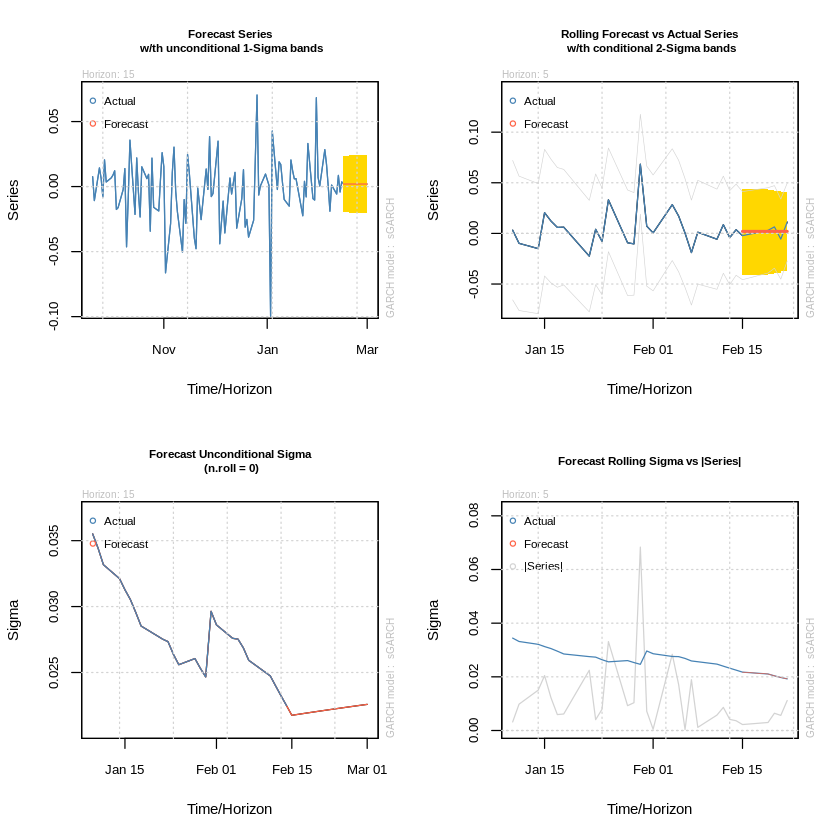

In [422]:
# Plot diagnostics of fit
plot(forecast_garch_11, which = "all")

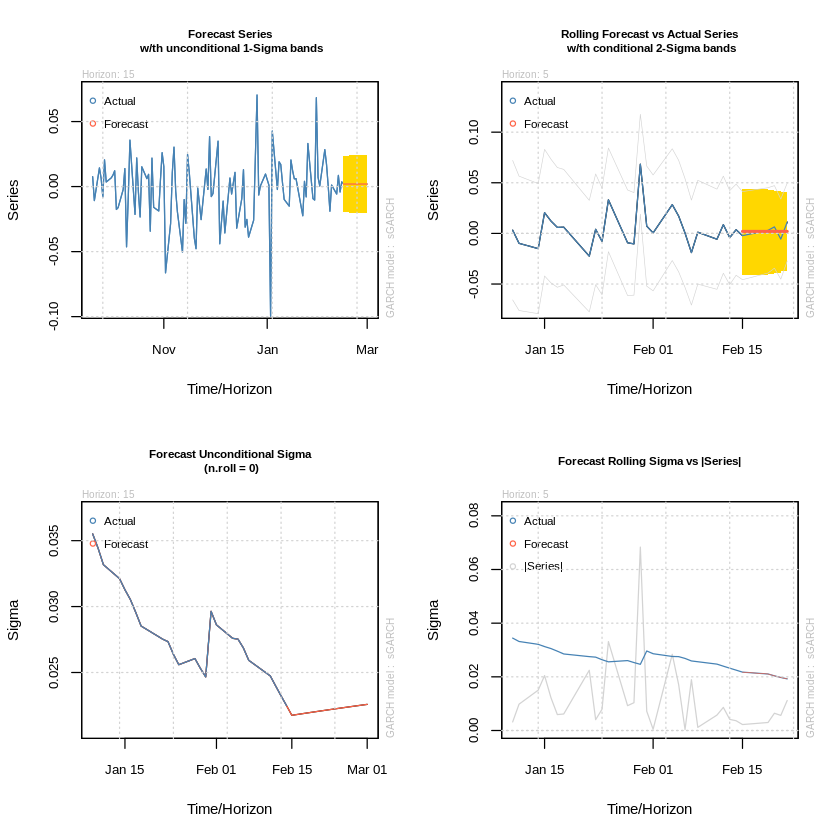

In [393]:
# Plot forcast of series
plot(forecast, which="all")

## Asymmetric GARCH

### TGARCH

In [444]:
spec_tgarch_11 = ugarchspec(
    variance.model = list( model = "fGARCH", submodel = "TGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0))
)
spec_tgarch_11
fit_tgarch_11 = ugarchfit(spec_tgarch_11, Returns, solver='hybrid', out.sample = 30)
fit_tgarch_11


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: fGARCH(1,1)
fGARCH Sub-Model	: TGARCH
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: fGARCH(1,1)
fGARCH Sub-Model	: TGARCH
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001607    0.000260   6.1896        0
omega   0.000420    0.000076   5.5067        0
alpha1  0.095212    0.009311  10.2257        0
beta1   0.911350    0.009377  97.1886        0
eta11   0.372888    0.048901   7.6254        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001607    0.000313   5.1312 0.000000
omega   0.000420    0.000164   2.5588 0.010503
alpha1  0.095212    0.027032   3.5222 0.000428
beta1   0.911350    0.024959  36.5139 0.000000
eta11   0.372888    0.075080   4.9665 0.000001

LogLikelihood : 11589.88 

Information Criteria
---------------------------


please wait...calculating quantiles...


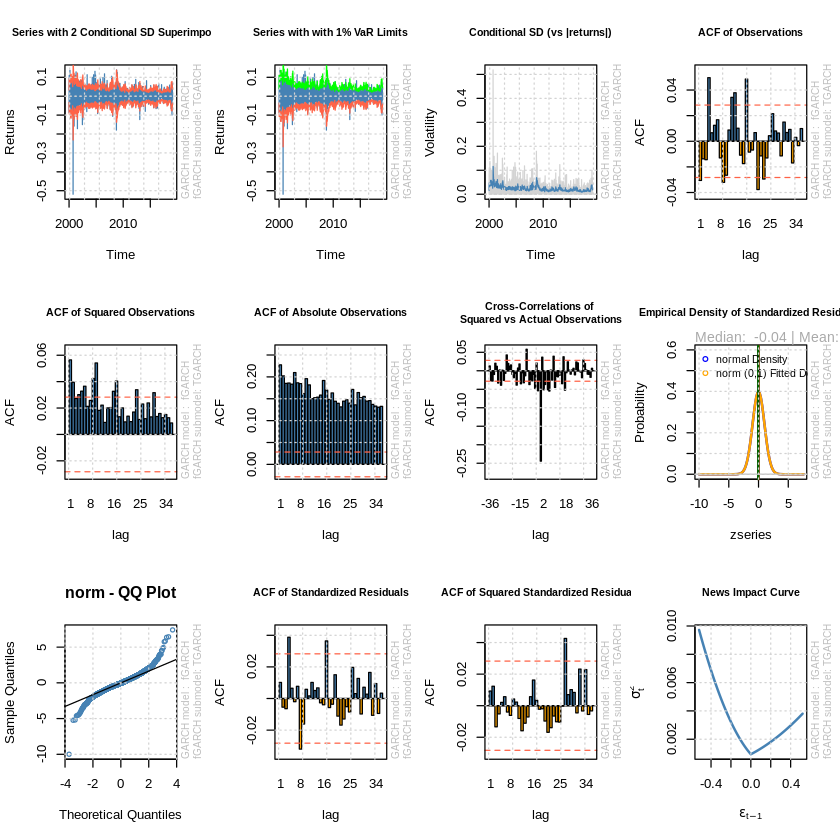

In [434]:
plot(fit_tgarch_11, which = "all")

### EGARCH

In [445]:
spec_egarch_11 = ugarchspec(mean.model = list(armaOrder = c(0,0)), variance.model= list(garchOrder = c(1,1), model="eGARCH"))
show(spec_egarch_11)
fit_egarch_11 = ugarchfit(spec_egarch_11, Returns, solver='hybrid', out.sample = 30)
fit_egarch_11


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: eGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 




*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001671    0.000320   5.2216        0
omega  -0.117904    0.010479 -11.2514        0
alpha1 -0.056031    0.007641  -7.3326        0
beta1   0.983375    0.001327 740.8497        0
gamma1  0.157625    0.013045  12.0832        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001671    0.000542   3.0844 0.002040
omega  -0.117904    0.029518  -3.9944 0.000065
alpha1 -0.056031    0.013044  -4.2954 0.000017
beta1   0.983375    0.003409 288.4905 0.000000
gamma1  0.157625    0.048721   3.2353 0.001215

LogLikelihood : 11591.07 

Information Criteria
------------------------------------
                


please wait...calculating quantiles...


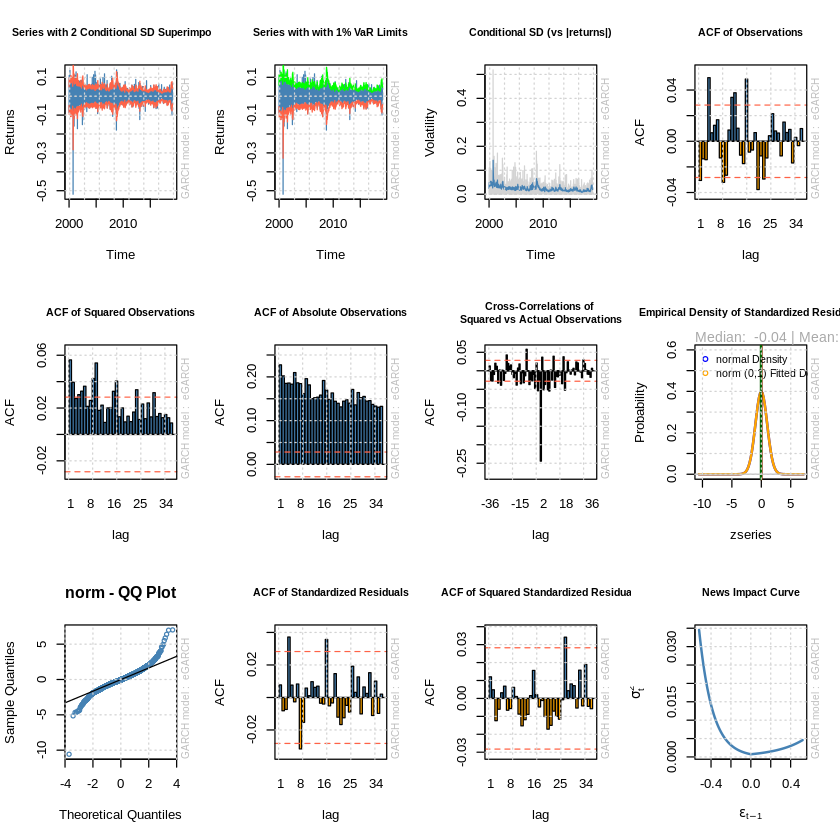

In [447]:
plot(fit_egarch_11, which="all")

In [448]:
forecast_egarch_11 = ugarchforecast(fit_egarch_11, n.ahead=15, n.roll=5)
forecast_egarch_11


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: eGARCH
Horizon: 15
Roll Steps: 5
Out of Sample: 15

0-roll forecast [T0=2019-02-14]:
       Series   Sigma
T+1  0.001671 0.01858
T+2  0.001671 0.01872
T+3  0.001671 0.01885
T+4  0.001671 0.01899
T+5  0.001671 0.01912
T+6  0.001671 0.01925
T+7  0.001671 0.01938
T+8  0.001671 0.01951
T+9  0.001671 0.01964
T+10 0.001671 0.01976
T+11 0.001671 0.01989
T+12 0.001671 0.02001
T+13 0.001671 0.02013
T+14 0.001671 0.02025
T+15 0.001671 0.02037



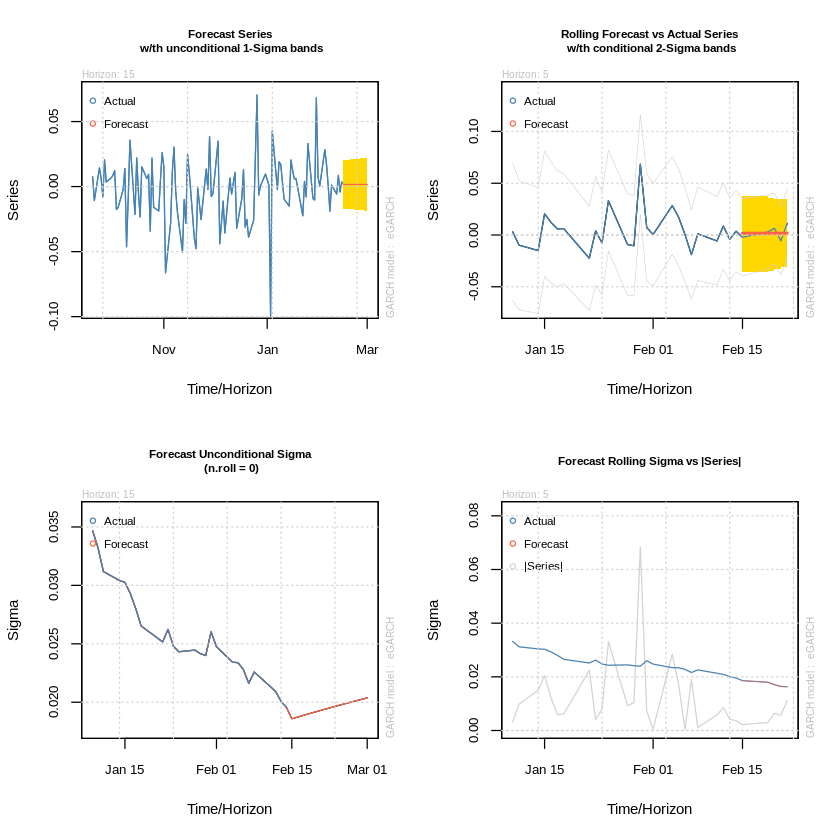

In [449]:
plot(forecast_egarch_11, which="all")

## Other Models

### ARCH

In [424]:
spec_garch_10 = ugarchspec(mean.model = list(armaOrder = c(0,0)), variance.model= list(garchOrder = c(1,0)))
show(spec_garch_10)
fit_garch_10 = ugarchfit(spec_garch_10, Returns, solver='hybrid', out.sample = 30)
fit_garch_10


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 




*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.119601    0.000040 2974.594        0
omega   0.000007    0.000001   10.727        0
alpha1  0.999000    0.000451 2213.723        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.119601    0.000438 272.7793  0.00000
omega   0.000007    0.000006   1.1816  0.23736
alpha1  0.999000    0.004535 220.2867  0.00000

LogLikelihood : 1575.533 

Information Criteria
------------------------------------
                     
Akaike       -0.65386
Bayes        -0.64982
Shibata      -0.65386
Hannan-Quinn -0.65244

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
      

### GARCH-M

In [441]:
spec_garchm_11 = ugarchspec(mean.model = list(armaOrder = c(0,0), archm = TRUE, archpow = 1))
show(spec_garchm_11)
fitt = ugarchfit(spec_garchm_11, Returns, solver='hybrid', out.sample = 30)
fitt


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: TRUE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 




*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002073    0.000881  2.35274 0.018636
archm  -0.006323    0.045476 -0.13903 0.889422
omega   0.000006    0.000002  2.75707 0.005832
alpha1  0.070454    0.009256  7.61133 0.000000
beta1   0.923156    0.010748 85.89406 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002073    0.001043  1.98751 0.046866
archm  -0.006323    0.053571 -0.11803 0.906046
omega   0.000006    0.000008  0.76041 0.447012
alpha1  0.070454    0.032656  2.15746 0.030970
beta1   0.923156    0.037283 24.76053 0.000000

LogLikelihood : 11538.94 

Information Criteria
------------------------------------
                

### IGARCH

The IGARCH model will be unsuitable for forecasting the returns process as the process is already stationary and does not benefit from futher integration.

## Summary

### Comparison of Viable Models


Model | Log Likelihood | AIC
--- | --- | ---
ARCH(1) | 1575.533 | -0.65386
GARCH(1,1) | 11538.93 | -4.7962
TGARCH(1,1) | 11589.88 | -4.8170
EGARCH(1,1) | 11591.07 | -4.8175
GARCH-M(1,1) | 11538.94 | -4.7958



In [ ]:
Sign Bias
http://r.789695.n4.nabble.com/Interpretation-of-sign-bias-test-in-rugarch-output-td4667502.html